In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

In [2]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [3]:
def rc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - length of pulse in symbol periods; pulse ranges for -N <= t/T <= N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)

    if np.min(np.abs(tt - 1/(2*a))) > 1e-6:
        # fast if there is no divide by zero
        return np.sinc(tt) * np.cos(np.pi*a*tt)/(1-(2*a*tt)**2)
    else:
        # deal with the case when 1-(2*a*tt)**2 = 0
        ss = np.sinc(tt)
        ind_0 = np.where(np.abs(np.abs(tt) - 1/(2*a)) < 1e-6)
        tt[ind_0] = 0        # replace the problem tt with something safe
        bb = np.cos(np.pi*a*tt)/(1-(2*a*tt)**2)
        bb[ind_0] = np.pi/4  # correct the value at problem tt

        return ss * bb

The Fourier transform of this pulse is given by
$$
H_{RC}(f) = \begin{cases}
    T & |fT| \leq \frac{1-a}{2} \\
    \frac{T}{2}(1 - \sin(\frac{\pi T}{a}(|f|-\frac{1}{2T}))) & \frac{1-a}{2} \leq |fT| \leq \frac{1+a}{2} \\
    0 & |fT| >  \frac{1+a}{2}
\end{cases}
$$

The raised cosine pulse is *strictly* band-limited and has two-sided bandwidth $\frac{1+a}{T}$. This is wwider (by $\frac{a}{T}$) than the minimum bandwidth. 

The extra bandwidth $\frac{a}{T}$ is called the *excess bandwidth*.

Note that the entire bandwidth $\frac{1+a}{T}$ fits in the mainlobe of the rectangular pulse (width $\frac{2}{T}$). This illustrates the benefits in terms of spectral containment of the raised cosine pulse.

In [4]:
def rc_spectrum(f, T, a):
    Hrc = np.zeros_like(f)
    # |fT| <= (1 - a) / 2
    mask_1 = np.abs(f * T) <= (1 - a) / 2
    Hrc[mask_1] = T
    # (1 - a) / 2 < |fT| <= (1 + a) / 2
    mask_2 = (np.abs(f * T) > (1 - a) / 2) & (np.abs(f * T) <= (1 + a) / 2)
    Hrc[mask_2] = T * 0.5 * (1 - np.sin(np.pi * T / a * (np.abs(f[mask_2]) - 1 / (2 * T))))
    return Hrc

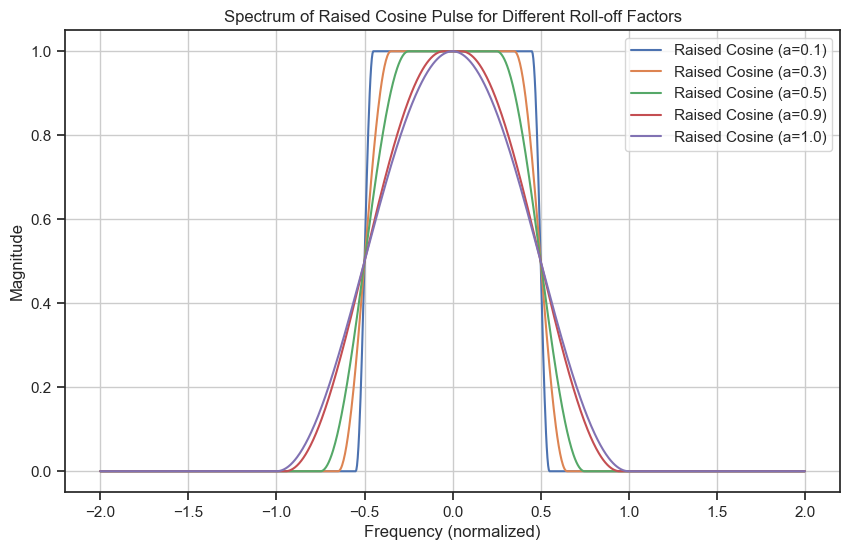

In [5]:
# plot the spectrum of raised cosine pulse
a_values = [0.1, 0.3, 0.5, 0.9, 1.0]  # Roll-off factor (a)
T = 1     # Symbol duration (normalized)
f = np.linspace(-2, 2, 1000)  # Frequency range (normalized)
plt.figure(figsize=(10, 6))
for a in a_values:
    Hrc= rc_spectrum(f, T, a)
    plt.plot(f, Hrc, label=f'Raised Cosine (a={a})')

# Set plot details
plt.title('Spectrum of Raised Cosine Pulse for Different Roll-off Factors')
plt.xlabel('Frequency (normalized)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.show()



In [6]:
def random_symbols(A, N):
    """generate random symbols from the constellation A

    Inputs:
    A: np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N: number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [7]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted

    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)
    for n in range(len(Z)):
        this_Z = Z[n]
        # print(A)
        # print(Z)
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [8]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal

    Inputs:
    symbols: a sequence of information symbols; rate 1/T
    pulse: sampled pulse shape; rate fsT/T
    fsT: samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [9]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N <= t/T <= N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [10]:
Es = 1
# Define a normalized QPSK constellation
qpsk_const = np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), np.exp(1j*7*np.pi/4)])
num_symbols = 1024
qpsk_sym = random_symbols(qpsk_const, num_symbols)
avg_sym_energy = 1/num_symbols * np.sum(np.abs(qpsk_sym)**2)
print("average symbol energy before pulse shaping: ", avg_sym_energy)
fsT = 16
# Pulse shaping
N = 5
a = 0.5
pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
mag_pp = np.sum(np.abs(pp)**2)
print("The energy of the pulse has to be one", mag_pp)
ss = pulse_shape(qpsk_sym, pp, fsT)
print("average symbol energy after pulse shaping: ", 1/num_symbols * np.sum(np.abs(ss)**2))


average symbol energy before pulse shaping:  1.0
The energy of the pulse has to be one 0.9999999999999998
average symbol energy after pulse shaping:  1.0001545010616633


In [11]:

def montecarlo_ser(roll_off,const,symbols,error):
    MAX_ERRORS=400
    MAX_BURSTS=1000
    N_bursts = 0
    N_errors = 0
    while N_bursts < MAX_BURSTS and N_errors < MAX_ERRORS:
        fsT = 16
        N = 5
        pp = srrc_pulse(roll_off, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
        ss = pulse_shape(qpsk_sym, pp, fsT)
        snr_db = 10
        SNR_LINEAR = 10**(snr_db/10)
        noise_var = Es/SNR_LINEAR
        sigma = np.sqrt(noise_var/2)
        noise = sigma*(np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # channel (add gaussian noise)
        tx_data = ss + noise
        # Receiver
        rx_data = tx_data
        # Apply matched filter
        mf = np.flip(pp)
        mf_out = np.convolve(rx_data, mf)
        d_samples = len(pp) - 1      # filter delay
        Z = mf_out[d_samples+error::fsT]        # down-sample, starting at filter delay
        # Z = mf_out[fsT:-fsT:fsT]
        # print(len(Z))
        dec = MPE_decision_rule(Z[:num_symbols], const) # Z[:N] trims extra samples from the filter transisent
        # print(len(dec))
        # dec = MPE_decision_rule(Z, const)

       # Evaluate simulation errors
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, symbols))

    # Simulated SER
    M = len(symbols) * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # print(N_errors)
 
        
    return Z, mf_out, ser_sim

In [12]:
# Question 4a
errors = []
ser_simulated_qpsk = []
roll_off = 0.5
for err in range(-8,9,1):
    Z, mf_out,ser_sim = montecarlo_ser(roll_off, qpsk_const,qpsk_sym,err)
    ser_simulated_qpsk.append(ser_sim)
    errors.append(err)

In [14]:
ser_simulated_qpsk

[0.4267578125,
 0.29638671875,
 0.1591796875,
 0.0869140625,
 0.033772786458333336,
 0.01171875,
 0.004595588235294118,
 0.0023507672155688624,
 0.0015237414883268483,
 0.0023229474852071007,
 0.0049072265625,
 0.012758316532258064,
 0.034912109375,
 0.082421875,
 0.16861979166666666,
 0.28564453125,
 0.4208984375]

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_9228/1519531377.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(np.array(errors)/fsT, ser_simulated_qpsk, 'ko', marker='o', linestyle='-')


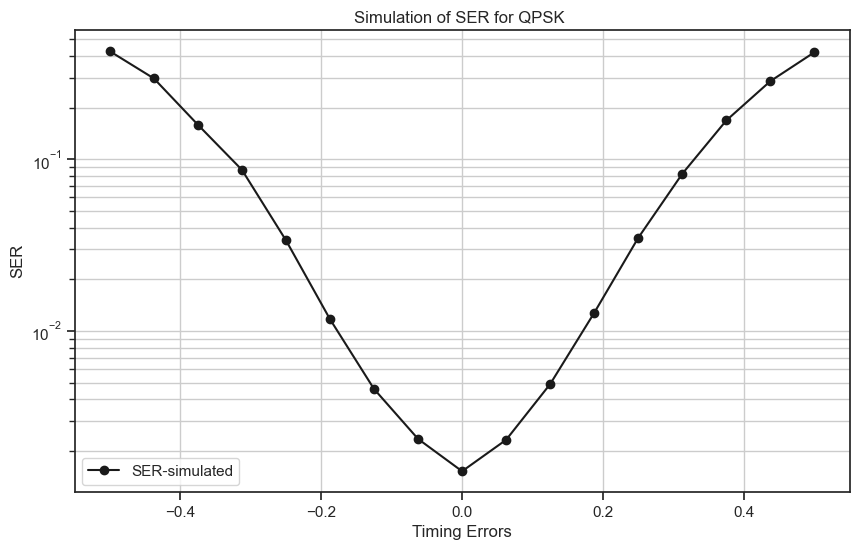

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(errors)/fsT, ser_simulated_qpsk, 'ko', marker='o', linestyle='-')
plt.yscale('log')
plt.xlabel('Timing Errors')
plt.ylabel('SER')
plt.title('Simulation of SER for QPSK ')
plt.grid(True, which="both")  
plt.legend(['SER-simulated','SER-exact' ])
plt.show()

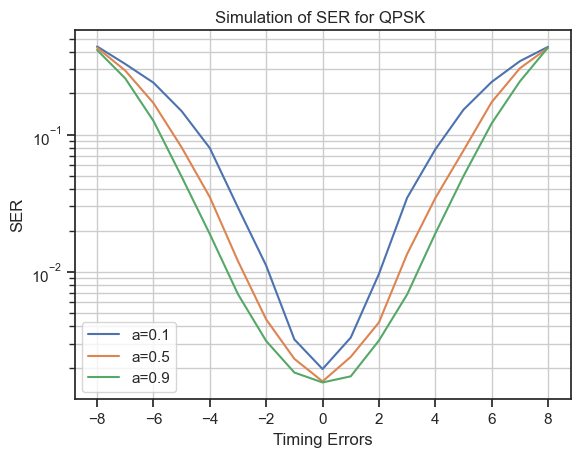

In [16]:
# Question 4b
roll_offs = [0.1,0.5,0.9]
for a in roll_offs:
    errors = []
    ser_simulated_qpsk = []
    for err in range(-8,9,1):
        Z, mf_out,ser_sim = montecarlo_ser(a, qpsk_const,qpsk_sym,err)
        ser_simulated_qpsk.append(ser_sim)
        errors.append(err)
    plt.plot(errors, ser_simulated_qpsk, label='a={:3.1f}'.format(a))
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.yscale('log')
plt.xlabel('Timing Errors')
plt.ylabel('SER')
plt.legend()  # Show legends for each roll-off factor
plt.title('Simulation of SER for QPSK ')
plt.show()
    

In [ ]:
for a in [0.1, 0.3, 0.5, 0.9, 1.0]:
    pulse = rc_pulse(a, fsT, N)
    plt.plot(tt, rc_pulse(a, fsT, N), label='a={:3.1f}'.format(a))
    # plt.plot(tt, rc_pulse2(a, fsT, N), label='a={:3.1f}'.format(a))
plt.grid()
plt.xlabel('Time $t/T$')
plt.legend()

plt.show()

In [93]:

def montecarlo_ser(roll_off,const,symbols,error):
    MAX_ERRORS=400
    MAX_BURSTS=1
    N_bursts = 0
    N_errors = 0
    while N_bursts < MAX_BURSTS and N_errors < MAX_ERRORS:
        fsT = 16
        N = 5
        pp = srrc_pulse(roll_off, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
        ss = pulse_shape(qpsk_sym, pp, fsT)
        snr_db = 10
        SNR_LINEAR = 10**(snr_db/10)
        noise_var = Es/SNR_LINEAR
        sigma = np.sqrt(noise_var/2)
        noise = sigma*(np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # channel (add gaussian noise)
        tx_data = ss + noise
        # Receiver
        rx_data = tx_data
        # Apply matched filter
        mf = np.flip(pp)
        mf_out = np.convolve(rx_data, mf)
        d_samples = len(pp) - 1      # filter delay
        Z = mf_out[d_samples+error::fsT]        # down-sample, starting at filter delay
        # Z = mf_out[fsT:-fsT:fsT]
        # print(len(Z))
        dec = MPE_decision_rule(Z[:num_symbols], const) # Z[:N] trims extra samples from the filter transisent
        # print(len(dec))
        # dec = MPE_decision_rule(Z, const)

       # Evaluate simulation errors
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, symbols))
        print("Total errors", N_errors )

    # Simulated SER
    M = len(symbols) * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # print(N_errors)
 
        
    return Z, mf_out, ser_sim

In [97]:
# Testing
Es = 1
# Define a normalized QPSK constellation
qpsk_const = np.array([np.exp(1j*np.pi/4), np.exp(1j*3*np.pi/4), np.exp(1j*5*np.pi/4), np.exp(1j*7*np.pi/4)])
num_symbols = 1024
qpsk_sym = random_symbols(qpsk_const, num_symbols)
print(len(qpsk_sym))
avg_sym_energy = 1/num_symbols * np.sum(np.abs(qpsk_sym)**2)
print("average symbol energy before pulse shaping: ", avg_sym_energy)
fsT = 16
# Pulse shaping
N = 5
a = 0.5
pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
mag_pp = np.sum(np.abs(pp)**2)
print("The energy of the pulse has to be one", mag_pp)
ss = pulse_shape(qpsk_sym, pp, fsT)
print("average symbol energy after pulse shaping: ", 1/num_symbols * np.sum(np.abs(ss)**2))

errors = []
ser_simulated_qpsk = []
roll_off = 0.5
err = 5
Z, mf_out,ser_sim = montecarlo_ser(roll_off, qpsk_const,qpsk_sym,err)
ser_simulated_qpsk.append(ser_sim)
errors.append(err)

1024
average symbol energy before pulse shaping:  1.0
The energy of the pulse has to be one 0.9999999999999998
average symbol energy after pulse shaping:  0.9997566707577382
Total errors 92


In [98]:
qpsk_sym

array([ 0.70710678+0.70710678j, -0.70710678-0.70710678j,
        0.70710678+0.70710678j, ...,  0.70710678-0.70710678j,
       -0.70710678-0.70710678j, -0.70710678-0.70710678j])

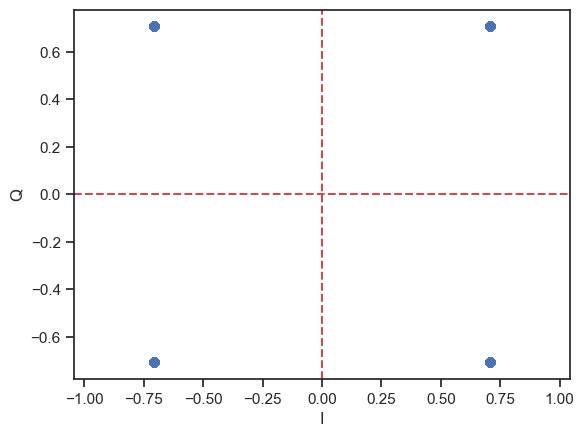

In [99]:
plt.plot(np.real(qpsk_sym), np.imag(qpsk_sym), 'o')

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


plt.show()

In [100]:
# Z

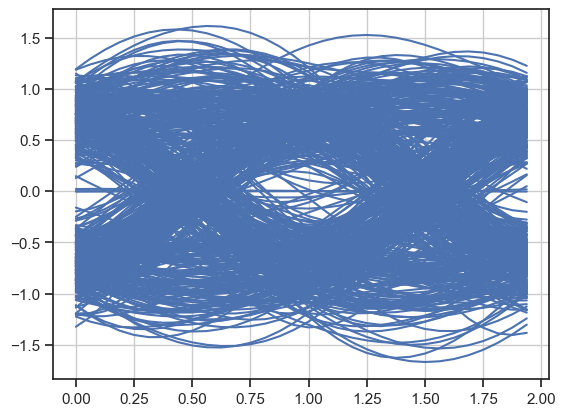

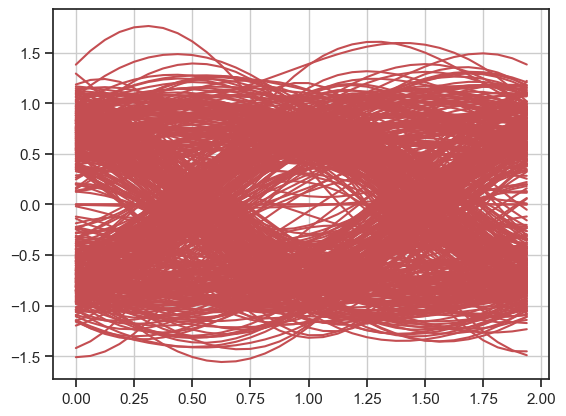

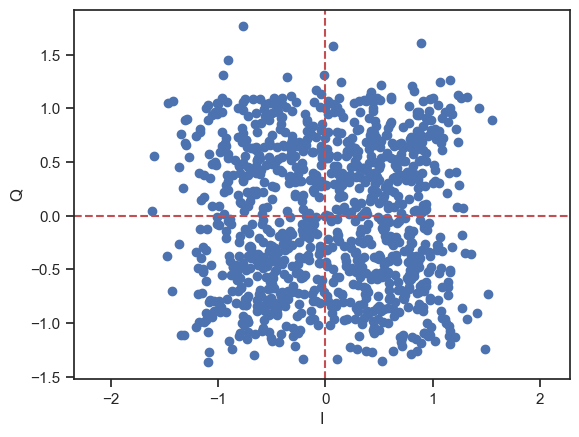

In [101]:
  # Eye Diagram plot of real part only
for n in range(len(ss)//(2*fsT)):
    plt.plot(np.arange(2*fsT)/fsT, np.real(mf_out[n*2*fsT:(n+1)*2*fsT]), 'b')

plt.grid()
plt.show()

# Eye Diagram plot of imaginary part only
for n in range(len(ss)//(2*fsT)):
    plt.plot(np.arange(2*fsT)/fsT, np.imag(mf_out[n*2*fsT:(n+1)*2*fsT]), 'r')

plt.grid()
plt.show()

plt.plot(np.real(Z), np.imag(Z), 'o')

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


plt.show()

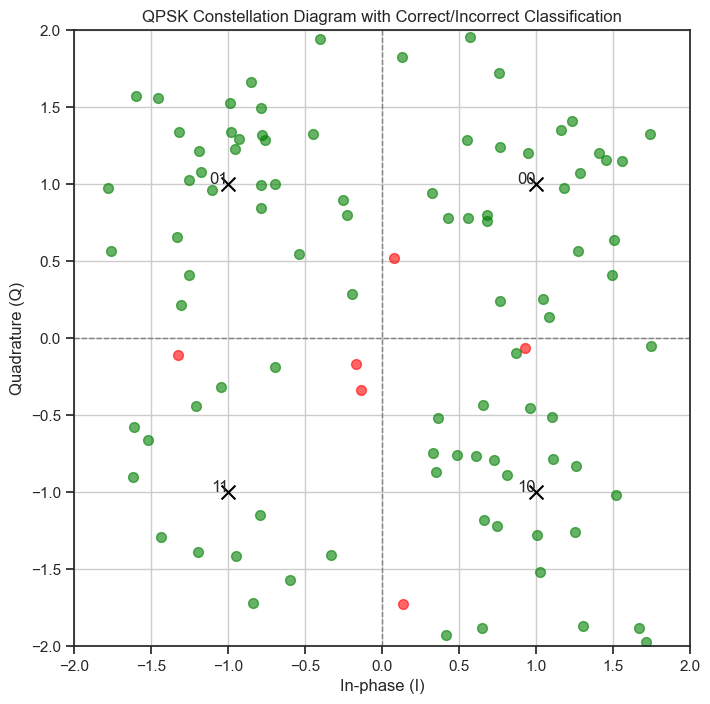

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Define QPSK symbol mapping
ideal_symbols = {
    '00': (1, 1),
    '01': (-1, 1),
    '11': (-1, -1),
    '10': (1, -1)
}

# Define decision boundaries for QPSK
def decision_boundary(x, y):
    if x >= 0 and y >= 0:
        return '00'  # Top-right quadrant
    elif x < 0 and y >= 0:
        return '01'  # Top-left quadrant
    elif x < 0 and y < 0:
        return '11'  # Bottom-left quadrant
    elif x >= 0 and y < 0:
        return '10'  # Bottom-right quadrant

# Generate some received symbols with noise for demonstration
np.random.seed(0)
received_symbols = []
num_symbols = 100

for _ in range(num_symbols):
    ideal_key = np.random.choice(list(ideal_symbols.keys()))
    ideal_point = ideal_symbols[ideal_key]
    # Add Gaussian noise to the ideal points
    received_point = (ideal_point[0] + np.random.normal(0, 0.5), 
                      ideal_point[1] + np.random.normal(0, 0.5))
    received_symbols.append((ideal_key, received_point))

# Visualize the constellation diagram with decision boundaries
plt.figure(figsize=(8, 8))

# Plot decision boundaries
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Plot ideal symbol positions
for key, (x, y) in ideal_symbols.items():
    plt.scatter(x, y, color='black', s=100, marker='x')
    plt.text(x, y, f'{key}', fontsize=12, ha='right')

# Plot received symbols with color coding based on correct/incorrect classification
for true_key, (x, y) in received_symbols:
    detected_key = decision_boundary(x, y)
    if detected_key == true_key:
        plt.scatter(x, y, color='green', s=50, alpha=0.6)  # Correct symbols in green
    else:
        plt.scatter(x, y, color='red', s=50, alpha=0.6)  # Incorrect symbols in red

# Labels and title
plt.title('QPSK Constellation Diagram with Correct/Incorrect Classification')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [104]:
a = [1,2,3,4,5,6,6,7,8,9,10]
a[-3:len(a)]

[8, 9, 10]